In [306]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [307]:
work_dir = '/kaggle/input/store-sales-time-series-forecasting/'

In [308]:
# Setup notebook
from pathlib import Path
# from learntools .time_series.style import *  # plot style settings
# from learntools.time_series.utils import plot_periodogram, seasonal_plot
# from learntools.time_series.utils import plot_lags, make_lags, make_leads

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge
from sklearn.preprocessing import LabelEncoder
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from sklearn.metrics import mean_squared_log_error, mean_squared_error
from statsmodels.graphics.tsaplots import plot_pacf
from xgboost import XGBRegressor
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor, BaggingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import RobustScaler, StandardScaler, Normalizer, MinMaxScaler
from sklearn.model_selection import train_test_split

import catboost as cb
from catboost import CatBoostRegressor
import lightgbm as lgb

In [309]:
train_data = pd.read_csv('train.csv')
train_data['date'] = pd.to_datetime(train_data['date'])

In [310]:
train_data.tail()

,id,date,store_nbr,family,sales,onpromotion
3000883,3000883,2017-08-15,9,POULTRY,438.133,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8
3000887,3000887,2017-08-15,9,SEAFOOD,16.000,0


In [311]:
holidays_data = pd.read_csv('holidays_events.csv')
holidays_data['date'] = pd.to_datetime(holidays_data['date'])
holidays_data.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [312]:
transactions_data = pd.read_csv('transactions.csv')
transactions_data['date'] = pd.to_datetime(transactions_data['date'])
transactions_data.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [313]:
train_data.isna().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

In [314]:
train_data['sales'] = np.log1p(train_data['sales'])
train_data.tail()

,id,date,store_nbr,family,sales,onpromotion
3000883,3000883,2017-08-15,9,POULTRY,6.084802,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,5.046987,1
3000885,3000885,2017-08-15,9,PRODUCE,7.791824,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,4.804021,8
3000887,3000887,2017-08-15,9,SEAFOOD,2.833213,0


In [315]:
stores_data = pd.read_csv('stores.csv')
stores_data.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [316]:
stores_data.shape

(54, 5)

Text(0.5, 1.0, 'Sales per month for each store')

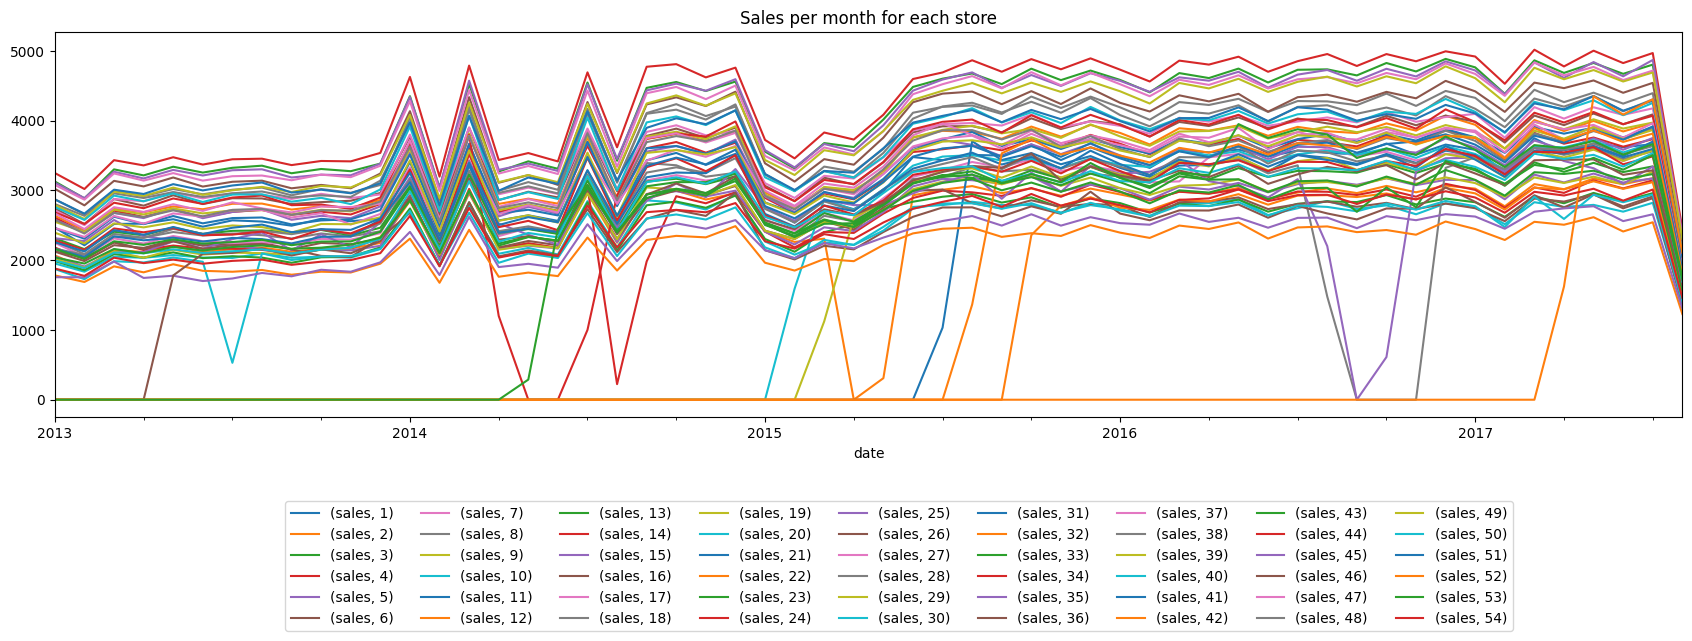

In [317]:
sales_per_store = (
    train_data
    .groupby(['date', 'store_nbr'])
    .aggregate({'sales': 'sum'})
    .unstack()
    .resample('1M')
    .sum()
)
sales_per_store.plot(figsize=(21,5))
plt.legend(bbox_to_anchor=(0.9,-.2), ncol=9)
plt.title("Sales per month for each store")

Text(0.5, 1.0, 'Sales per month for product family')

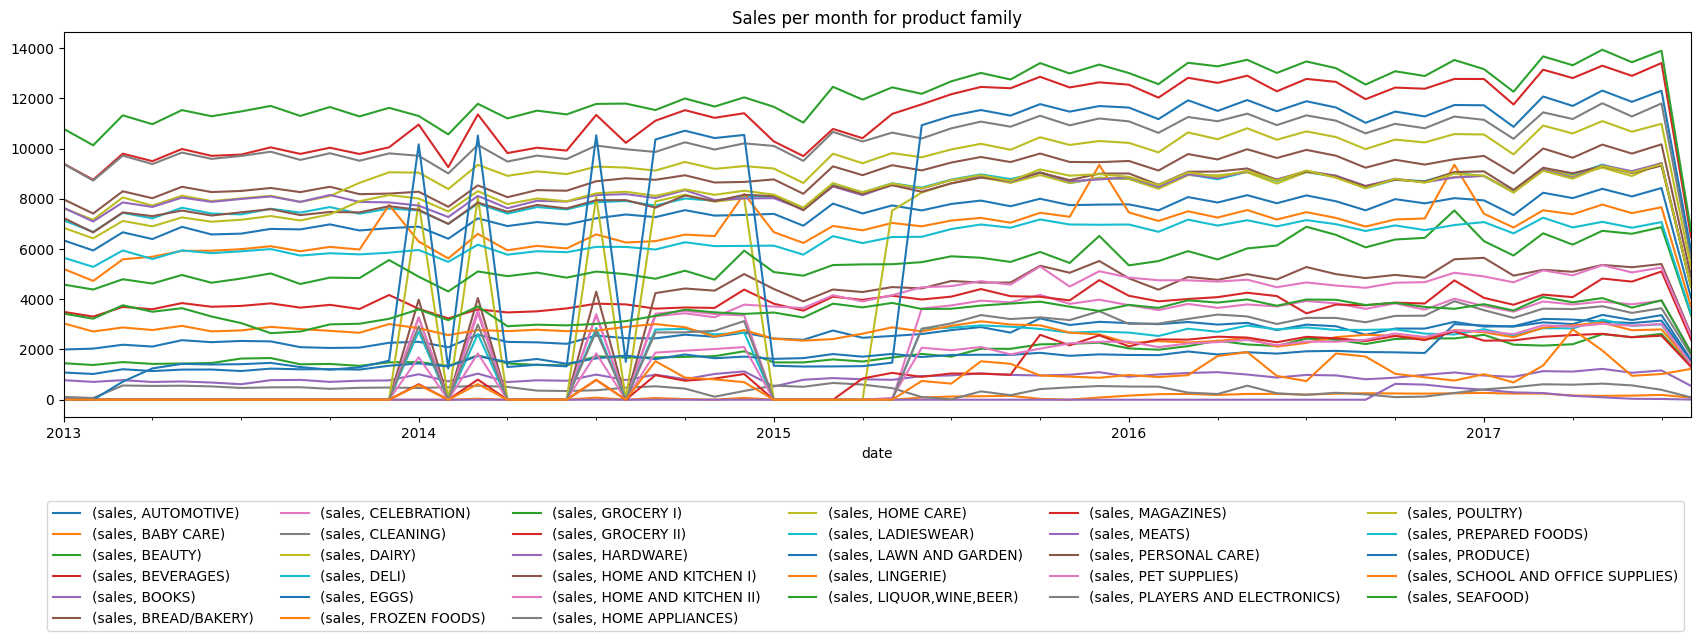

In [318]:
family_sales_per_month = (
    train_data
    .groupby(['date', 'family'])
    .aggregate({'sales': 'sum'})
    .unstack()
    .resample('1M')
    .sum()
)
family_sales_per_month.plot(figsize=(21,5))
plt.legend(bbox_to_anchor=(1, -.2), ncol=6)
plt.title("Sales per month for product family")

In [319]:
oil_data = pd.read_csv('oil.csv')
oil_data.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [320]:
oil_data.isna().sum()

date           0
dcoilwtico    43
dtype: int64

In [321]:
oil_data.fillna(method = 'ffill', inplace = True)
oil_data['date'] = pd.to_datetime(oil_data['date'])

In [322]:
oil_data.isna().sum()

date          0
dcoilwtico    1
dtype: int64

Text(0.5, 1.0, 'Oil price')

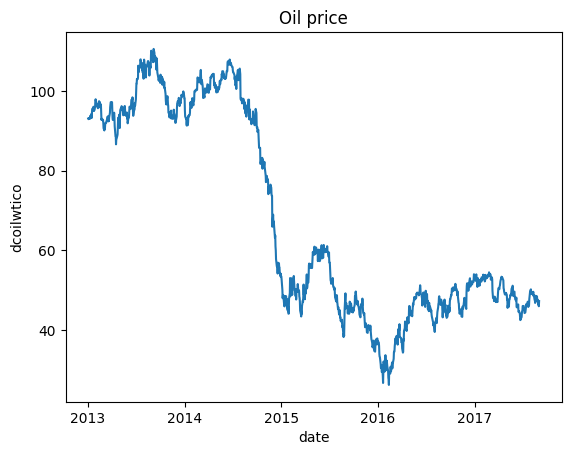

In [323]:
sns.lineplot(data=oil_data, x = 'date', y = 'dcoilwtico')
plt.title('Oil price')

In [324]:
# Function for adding lag features
def lag_features(df, lags):
    for lag in lags:
        df[f"sales_t-{lag}"] = df.groupby(["store_nbr", "family"])["sales"].transform(
            lambda x: x.shift(lag))
    return df

In [325]:
# Function for rolling average features
def roll_mean_features(df, windows):
    for window in windows:
        df['sales_roll_mean_' + str(window)] = df.groupby(["store_nbr", "family"])['sales']. \
                                                          transform(
            lambda x: x.shift(16).rolling(window=window, min_periods=7, win_type="triang").mean()) + random_noise(
            df)
    return df

In [326]:
# Random Noise
def random_noise(df):
    return np.random.normal(scale=2.0, size=(len(df),))


In [327]:
# Function for ewm features
def ewm_features(df, alphas, lags):
    for alpha in alphas:
        for lag in lags:
            df['sales_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                df.groupby(["store_nbr", "family"])['sales'].transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return df

In [328]:
# Calendar features
def create_date_features(df):
    df['month'] = df.date.dt.month
    df['day_of_month'] = df.date.dt.day
    df['day_of_year'] = df.date.dt.dayofyear
    df['week_of_year'] = df.date.dt.weekofyear
    df['day_of_week'] = df.date.dt.dayofweek
    df['year'] = df.date.dt.year
    return df

In [329]:
# Function to fill missing values
def fill_na(df):
    df['holiday_type'] = df['holiday_type'].fillna('Common')
    df['locale'] = df['locale'].fillna('Common')
    df['description'] = df['description'].fillna('Unknown')
    df['transferred'] = df['transferred'].fillna(False)
    df['dcoilwtico'] = df['dcoilwtico'].fillna(method='backfill')
    return df

In [330]:
# To merge all the created features 
def merge_data(df):
    df = df \
        .merge(stores_data, left_on="store_nbr", right_on="store_nbr", how="left") \
        .rename(columns={"type": "store_type"}) \
        .merge(transactions_data, left_on=["date", "store_nbr"], right_on=["date", "store_nbr"], how="left") \
        .merge(holidays_data, left_on="date", right_on="date", how="left") \
        .drop_duplicates(subset="id") \
        .rename(columns={"type": "holiday_type"}) \
        .merge(oil_data, left_on="date", right_on="date", how="left") 
    return df


In [331]:
use_cols = ['date','store_nbr','family','sales','onpromotion','cluster','holiday_type', 
    'locale','description','transferred','dcoilwtico']

In [332]:
test_data = pd.read_csv('test.csv'
)
test_data['date'] = pd.to_datetime(test_data['date'])
test_data.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


In [333]:
test_id = test_data['id']
test_data['date'] = pd.to_datetime(test_data['date'])

# **Complete data**

In [334]:
data = pd.concat([train_data, test_data], axis=0)
data = merge_data(data)
data = data[use_cols]
data = fill_na(data)
data = create_date_features(data)
# data = lag_features(data, lags = [*range(1, 16), 16,17,18,19,20,21,22,30,31,90,180,364])
# data = roll_mean_features(data,[16,17,18,30])

C:\Users\nibro\AppData\Local\Temp\ipykernel_24572\3897158039.py:6: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['week_of_year'] = df.date.dt.weekofyear


In [335]:
# data = ewm_features(data, [0.95, 0.9, 0.8, 0.5],[1, 7,30])

In [336]:
data['store_nbr'] = data['store_nbr'].astype('category')
data['family'] = data['family'].astype('category')
data['store_nbr'] = data['store_nbr'].astype('category')
data['cluster'] = data['cluster'].astype('category')
data['family'] = data['family'].astype('category')
data['holiday_type'] = data['holiday_type'].astype('category')
data['locale'] = data['locale'].astype('category')
data['description'] = data['description'].astype('category')

In [337]:
data.head()

,date,store_nbr,family,sales,onpromotion,cluster,holiday_type,locale,description,transferred,dcoilwtico,month,day_of_month,day_of_year,week_of_year,day_of_week,year
0,2013-01-01,1,AUTOMOTIVE,0.0,0,13,Holiday,National,Primer dia del ano,False,93.14,1,1,1,1,1,2013
1,2013-01-01,1,BABY CARE,0.0,0,13,Holiday,National,Primer dia del ano,False,93.14,1,1,1,1,1,2013
2,2013-01-01,1,BEAUTY,0.0,0,13,Holiday,National,Primer dia del ano,False,93.14,1,1,1,1,1,2013
3,2013-01-01,1,BEVERAGES,0.0,0,13,Holiday,National,Primer dia del ano,False,93.14,1,1,1,1,1,2013
4,2013-01-01,1,BOOKS,0.0,0,13,Holiday,National,Primer dia del ano,False,93.14,1,1,1,1,1,2013


In [338]:
data = data.query("date > '2013-12-31'")
X = data.query("date <= '2017-08-15'")
X_test = data.query("date > '2017-08-15'")
X.drop(['date'], inplace=True, axis=1)
X_test.drop(['date', 'year'], inplace=True, axis=1)

C:\Users\nibro\AppData\Local\Temp\ipykernel_24572\1646692899.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.drop(['date'], inplace=True, axis=1)
C:\Users\nibro\AppData\Local\Temp\ipykernel_24572\1646692899.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test.drop(['date', 'year'], inplace=True, axis=1)


In [339]:
corr = X.corr()
corr['sales'].sort_values(ascending=False)

C:\Users\nibro\AppData\Local\Temp\ipykernel_24572\2224134517.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = X.corr()


sales           1.000000
onpromotion     0.358192
year            0.123928
month           0.047753
day_of_year     0.047579
week_of_year    0.039054
day_of_week     0.024948
day_of_month   -0.001957
transferred    -0.006167
dcoilwtico     -0.117150
Name: sales, dtype: float64

<AxesSubplot: >

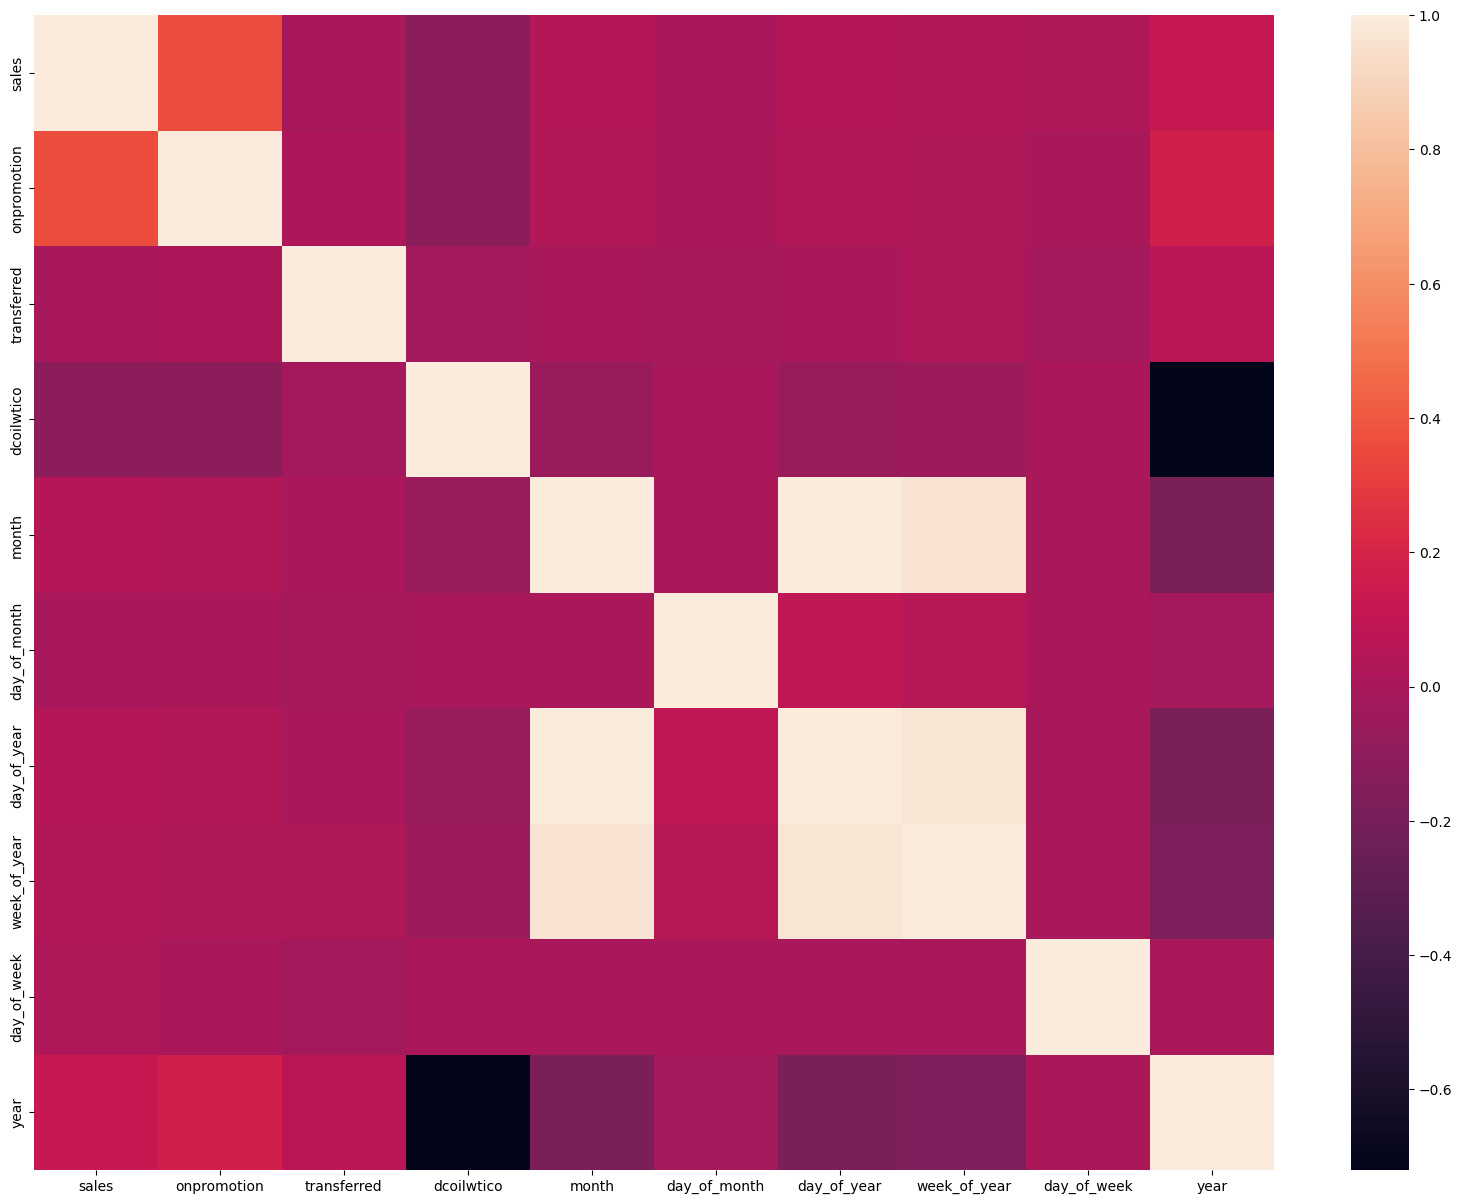

In [340]:
fig, ax = plt.subplots(figsize=(20,15)) 
sns.heatmap(corr, ax = ax)

In [341]:
Y = X['sales']
X = X.drop(['sales', 'year'], axis=1)
X_test = X_test.drop(['sales'], axis=1)

In [342]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

In [343]:
X_train.dtypes

store_nbr       category
family          category
onpromotion        int64
cluster         category
holiday_type    category
locale          category
description     category
transferred         bool
dcoilwtico       float64
month              int64
day_of_month       int64
day_of_year        int64
week_of_year       int64
day_of_week        int64
dtype: object

In [344]:
def recursive_predict(model):
    global X_test
    print(X_test.shape)
    output = np.array([])
    for day in range(16, 32):
        pred = model.predict(X_test.query(f"day_of_month == {day}"))
        pred[pred < 0] = 0
        output = np.concatenate([output, pred], axis=0)
        for k in range(day+1, 32):
            X_test.loc[X_test[X_test["day_of_month"] == k].index, f"sales_t-{k-day}"] = pred
    return output

In [345]:
lgb_params = {
    'metric': 'mse',
    'boosting_type' : 'gbdt',
    'num_leaves': 8,
    'learning_rate': 0.2,
    'max_depth': 7,
    'verbose': 0,
    'num_boost_round': 5000,
    'early_stopping_rounds': 200,
    'nthread': -1,
    'force_col_wise': True,
}

train_dataset = lgb.Dataset(data=X_train, label=Y_train, feature_name='auto')
val_dataset = lgb.Dataset(data=X_val, label=Y_val, reference=train_dataset, feature_name='auto')

In [346]:
model = lgb.train(
    params=lgb_params, 
    train_set=train_dataset,
    valid_sets=[train_dataset, val_dataset],
    verbose_eval=100,
)

C:\Users\nibro\AppData\Roaming\Python\Python310\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\nibro\AppData\Roaming\Python\Python310\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\nibro\AppData\Roaming\Python\Python310\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\nibro\AppData\Roaming\Python\Python310\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alia

Training until validation scores don't improve for 200 rounds
[100]	training's l2: 0.572684	valid_1's l2: 0.575294
[200]	training's l2: 0.464566	valid_1's l2: 0.466818
[300]	training's l2: 0.402627	valid_1's l2: 0.404951
[400]	training's l2: 0.36692	valid_1's l2: 0.369248
[500]	training's l2: 0.347222	valid_1's l2: 0.349848
[600]	training's l2: 0.321755	valid_1's l2: 0.32454
[700]	training's l2: 0.305408	valid_1's l2: 0.30865
[800]	training's l2: 0.294182	valid_1's l2: 0.297666
[900]	training's l2: 0.28532	valid_1's l2: 0.289064
[1000]	training's l2: 0.275584	valid_1's l2: 0.279748
[1100]	training's l2: 0.268177	valid_1's l2: 0.272613
[1200]	training's l2: 0.261481	valid_1's l2: 0.266051
[1300]	training's l2: 0.255168	valid_1's l2: 0.260038
[1400]	training's l2: 0.24868	valid_1's l2: 0.253783
[1500]	training's l2: 0.245078	valid_1's l2: 0.250516
[1600]	training's l2: 0.239873	valid_1's l2: 0.245588
[1700]	training's l2: 0.236441	valid_1's l2: 0.242437
[1800]	training's l2: 0.233586	val

In [347]:
Y_val_pred = model.predict(X_val, num_iteration=model.best_iteration)
Y_val_pred[Y_val_pred < 0] = 0
print(np.sqrt(mean_squared_error(Y_val, Y_val_pred)))
print(mean_squared_log_error(np.expm1(Y_val), np.expm1(Y_val_pred)))

0.43431145569224633
0.18862644054551805


In [348]:
X_test.head(10)

,store_nbr,family,onpromotion,cluster,holiday_type,locale,description,transferred,dcoilwtico,month,day_of_month,day_of_year,week_of_year,day_of_week
3000888,1,AUTOMOTIVE,0,13,Common,Common,Unknown,False,46.8,8,16,228,33,2
3000889,1,BABY CARE,0,13,Common,Common,Unknown,False,46.8,8,16,228,33,2
3000890,1,BEAUTY,2,13,Common,Common,Unknown,False,46.8,8,16,228,33,2
3000891,1,BEVERAGES,20,13,Common,Common,Unknown,False,46.8,8,16,228,33,2
3000892,1,BOOKS,0,13,Common,Common,Unknown,False,46.8,8,16,228,33,2
3000893,1,BREAD/BAKERY,12,13,Common,Common,Unknown,False,46.8,8,16,228,33,2
3000894,1,CELEBRATION,0,13,Common,Common,Unknown,False,46.8,8,16,228,33,2
3000895,1,CLEANING,25,13,Common,Common,Unknown,False,46.8,8,16,228,33,2
3000896,1,DAIRY,45,13,Common,Common,Unknown,False,46.8,8,16,228,33,2
3000897,1,DELI,18,13,Common,Common,Unknown,False,46.8,8,16,228,33,2


In [349]:
rec_pred_lgb = recursive_predict(model)

(28512, 14)


LightGBMError: The number of features in data (29) is not the same as it was in training data (14).
You can set ``predict_disable_shape_check=true`` to discard this error, but please be aware what you are doing.

In [350]:
X_test = data.query("date > '2017-08-15'")
X_test.drop(['date', 'year', 'sales'], inplace=True, axis=1)

C:\Users\nibro\AppData\Local\Temp\ipykernel_24572\3638119972.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test.drop(['date', 'year', 'sales'], inplace=True, axis=1)


In [351]:
cat_indices = np.where(X_train.dtypes == 'category')[0]
train_dataset_cb = cb.Pool(X_train, Y_train, cat_features=cat_indices)
val_dataset_cb = cb.Pool(X_val, Y_val, cat_features=cat_indices)

model_cb = CatBoostRegressor(
    loss_function='RMSE',
    cat_features=cat_indices,
    max_depth=7,
    n_estimators=100
)
model_cb.fit(train_dataset_cb, eval_set=val_dataset_cb)

Learning rate set to 0.5
0:	learn: 1.8358826	test: 1.8294123	best: 1.8294123 (0)	total: 487ms	remaining: 48.2s
1:	learn: 1.5454234	test: 1.5390870	best: 1.5390870 (1)	total: 891ms	remaining: 43.7s
2:	learn: 1.2931533	test: 1.2824957	best: 1.2824957 (2)	total: 1.28s	remaining: 41.6s
3:	learn: 1.1919512	test: 1.1839092	best: 1.1839092 (3)	total: 1.77s	remaining: 42.4s
4:	learn: 1.1560453	test: 1.1480472	best: 1.1480472 (4)	total: 2.12s	remaining: 40.4s
5:	learn: 1.1264291	test: 1.1205126	best: 1.1205126 (5)	total: 2.46s	remaining: 38.6s
6:	learn: 1.1155588	test: 1.1097678	best: 1.1097678 (6)	total: 2.81s	remaining: 37.4s
7:	learn: 1.1069346	test: 1.1012276	best: 1.1012276 (7)	total: 3.17s	remaining: 36.5s
8:	learn: 1.0986242	test: 1.0930599	best: 1.0930599 (8)	total: 3.54s	remaining: 35.8s
9:	learn: 1.0927104	test: 1.0872206	best: 1.0872206 (9)	total: 3.86s	remaining: 34.7s
10:	learn: 1.0725085	test: 1.0669691	best: 1.0669691 (10)	total: 4.18s	remaining: 33.8s
11:	learn: 1.0686392	test: 

In [352]:
Y_val_pred_cb = model_cb.predict(X_val)
Y_val_pred_cb[Y_val_pred_cb < 0] = 0
print(np.sqrt(mean_squared_error(Y_val, Y_val_pred_cb)))
print(mean_squared_log_error(np.expm1(Y_val), np.expm1(Y_val_pred_cb)))

0.9252104472766359
0.8560143717498327


In [ ]:
rec_pred_cb = recursive_predict(model_cb)

(28512, 14)


In [259]:
X_test = data.query("date > '2017-08-15'")
X_test.drop(['date', 'year', 'sales'], inplace=True, axis=1)

C:\Users\nibro\AppData\Local\Temp\ipykernel_24572\3638119972.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test.drop(['date', 'year', 'sales'], inplace=True, axis=1)


In [353]:
final_submission = pd.DataFrame({'id': test_id, 'sales': np.expm1(Y_val_pred)})
final_submission.to_csv('submission.csv', index=False)

ValueError: array length 470448 does not match index length 28512